# Exploratory Data Analysis

- Structure & Basic Info
- Summary Statistics
- Vizualizing Distributions
- Exploring Relationships
- Spotting Issues

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/kolesnikevgenia/Documents/Python_Projects/Job_Skills/Raw_Data/df_Final.csv')

### Structure & Basic Info

In [3]:
df.shape


(22003, 20)

In [4]:
df.dtypes

job_title_short           object
job_title                 object
job_location              object
job_via                   object
job_schedule_type         object
job_work_from_home          bool
search_location           object
job_posted_date           object
job_no_degree_mention       bool
job_health_insurance        bool
job_country               object
salary_rate               object
company_name              object
job_skills                object
job_type_skills           object
salary_year_avg_eur      float64
salary_month_avg_eur     float64
country                   object
is_eu                       bool
region_group              object
dtype: object

In [5]:
df.isna().sum()

job_title_short              0
job_title                    0
job_location               280
job_via                      0
job_schedule_type           16
job_work_from_home           0
search_location              0
job_posted_date              0
job_no_degree_mention        0
job_health_insurance         0
job_country                  0
salary_rate                  0
company_name                 0
job_skills                1833
job_type_skills           1833
salary_year_avg_eur          0
salary_month_avg_eur         0
country                  20349
is_eu                        0
region_group                 0
dtype: int64

### Summary Statistics

In [6]:
#Numeric column
df['salary_month_avg_eur'].describe().round(0).astype(int)

count    22003
mean      9049
std       3546
min       1101
25%       6606
50%       8441
75%      11010
max      70464
Name: salary_month_avg_eur, dtype: int64

In [7]:
#Categorical counts
df['job_title_short'].value_counts().head(10)

job_title_short
Data Scientist               5922
Data Analyst                 5451
Data Engineer                4500
Senior Data Scientist        1690
Senior Data Engineer         1591
Senior Data Analyst          1131
Business Analyst              610
Machine Learning Engineer     576
Software Engineer             467
Cloud Engineer                 65
Name: count, dtype: int64

In [8]:
df['job_country'].value_counts().head(10)

job_country
United States     15766
Sudan              1623
India               582
Canada              463
United Kingdom      287
Germany             257
France              237
Poland              200
Spain               144
Portugal            131
Name: count, dtype: int64

In [9]:
#Median salary by country
df.groupby('job_country')['salary_month_avg_eur'].median().sort_values(ascending=False).round(0).astype(int).head(10)

job_country
Belarus                     29360
Russia                      22020
Bahamas                     15276
Dominican Republic          11560
Northern Mariana Islands    11413
Tunisia                     10826
Côte d'Ivoire               10826
Chile                       10716
Namibia                     10056
Sudan                        9505
Name: salary_month_avg_eur, dtype: int64

In [10]:
#Exploring median salaries by country
df = df.dropna(subset=['salary_month_avg_eur'])

country_salary_stats = (
    df.groupby('job_country')
    .agg(job_count=('salary_month_avg_eur', 'count'),
         avg_salary=('salary_month_avg_eur', 'mean'))
         .sort_values(by='avg_salary', ascending=False)
         ).round(0).astype(int)

country_salary_stats.head(10)

,job_count,avg_salary
job_country,,
Belarus,1,29360
Russia,4,21470
Bahamas,21,14791
Dominican Republic,1,11560
Northern Mariana Islands,1,11413
Côte d'Ivoire,1,10826
Namibia,7,10339
Sudan,1623,9839
United States,15766,9258


### Visualizing Distributions

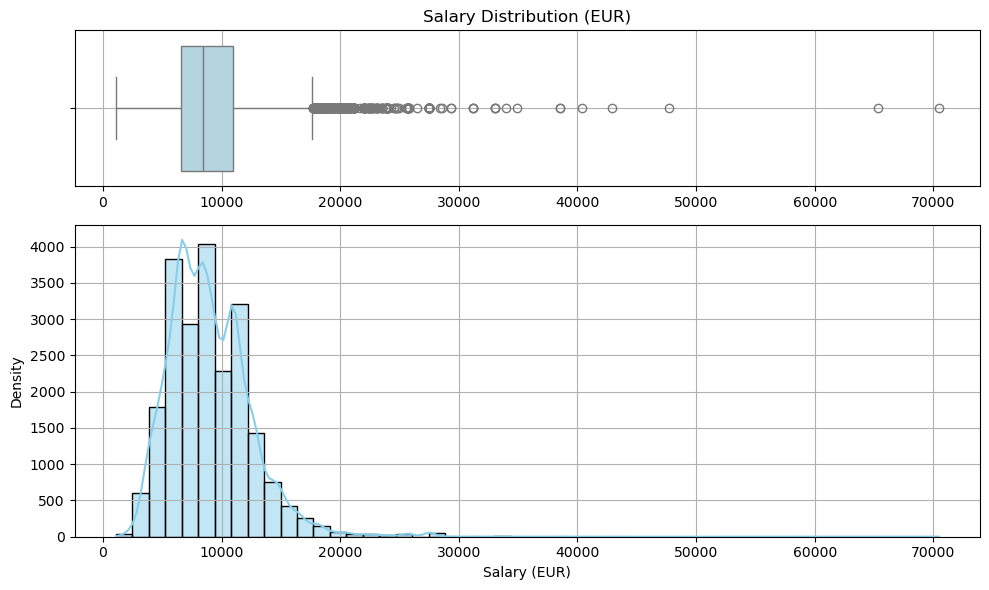

In [19]:
data = df['salary_month_avg_eur'].dropna()
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# --- Boxplot
sns.boxplot(x=data, ax=ax1, color='lightblue')
ax1.set_title('Salary Distribution (EUR)')
ax1.set_xlabel('')
ax1.grid(True)

# --- Histogram
sns.histplot(data, bins=50, kde=True, ax=ax2, color='skyblue', edgecolor='black')
ax2.set_xlabel('Salary (EUR)')
ax2.set_ylabel('Density')
ax2.grid(True)

plt.tight_layout()
plt.show()

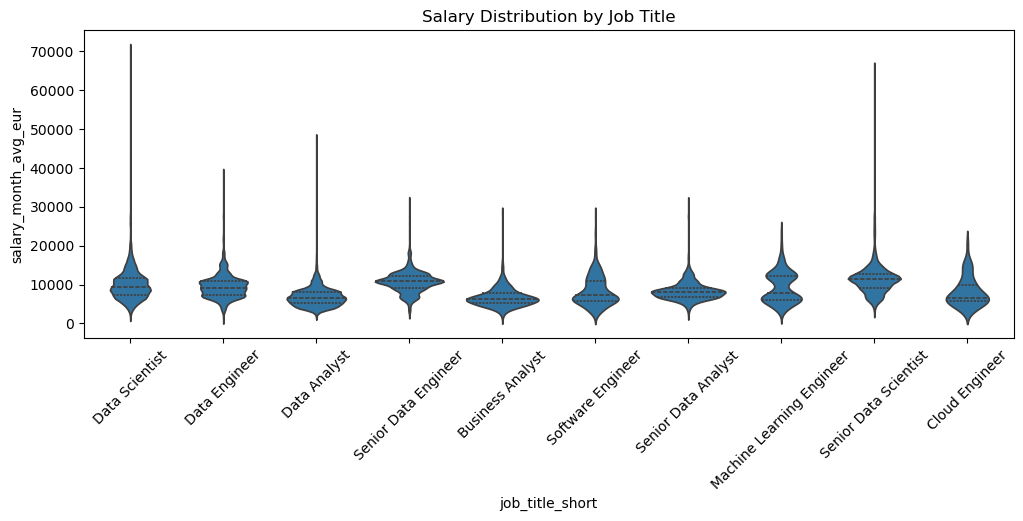

In [17]:
plt.figure(figsize=(12, 4))
sns.violinplot(data=df, x='job_title_short', y='salary_month_avg_eur', inner='quartile')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

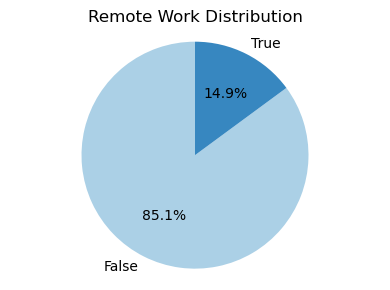

In [31]:
# Remote Work True/False
counts = df['job_work_from_home'].value_counts()
colors = sns.color_palette("Blues", n_colors=2)

fig, ax = plt.subplots(figsize=(4, 3))
ax.pie(
    counts,
    labels=counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax.set_title('Remote Work Distribution')
ax.axis('equal')  # Keep it circular

plt.tight_layout()
plt.show()

### Exploring Relationships

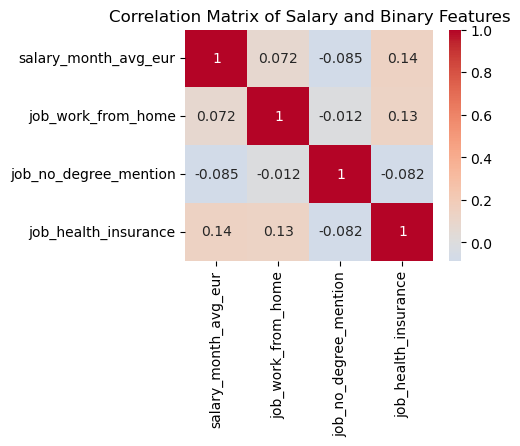

In [39]:
df_corr = df.copy()
bool_cols = ['job_work_from_home', 'job_no_degree_mention', 'job_health_insurance']
for col in bool_cols:
    df_corr[col] = df_corr[col].astype(int)

numeric_cols = ['salary_month_avg_eur'] + bool_cols
corr = df_corr[numeric_cols].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Salary and Binary Features')
plt.show()

The resulting correlation matrix shows that **all correlations are weak** (|r| < 0.15). A small positive correlation is observed between salary and features such as **health insurance** (r ≈ 0.14) and **remote work** (r ≈ 0.072).

These weak relationships suggest that no single binary feature strongly predicts salary on its own. This insight helps guide the analysis toward more complex combinations of factors or job-level groupings that may influence salary more significantly.

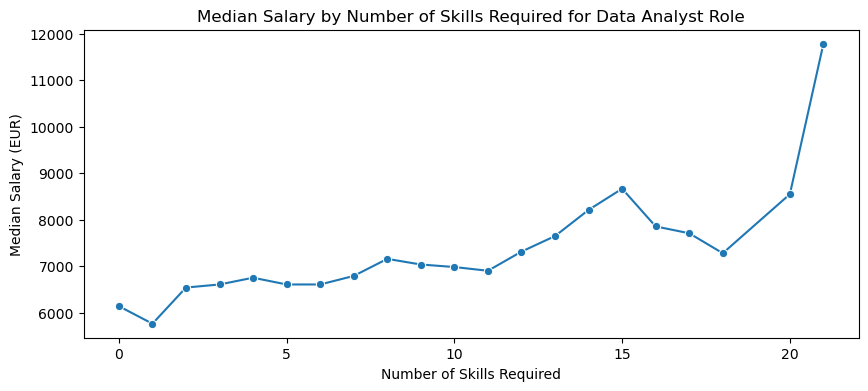

In [30]:
# Filter dataset to Data Analyst only
df_da = df[df['job_title_short'] == 'Data Analyst'].copy()

# Count skills function (comma-separated assumed)
def count_skills(skills_str):
    if pd.isna(skills_str) or skills_str.strip() == '':
        return 0
    return len([s for s in skills_str.split(',') if s.strip() != ''])

# Add skills_count column
df_da['skills_count'] = df_da['job_skills'].apply(count_skills)

# Median salary by skills count
median_salary_by_skills = df_da.groupby('skills_count')['salary_month_avg_eur'].median().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='skills_count', y='salary_month_avg_eur', data=median_salary_by_skills, marker='o')
plt.title('Median Salary by Number of Skills Required for Data Analyst Role')
plt.xlabel('Number of Skills Required')
plt.ylabel('Median Salary (EUR)')
plt.show()

### Spotting Issues

In [15]:
# Check for duplicates
print(df.duplicated().sum())

1


In [16]:
df[df.duplicated(keep=False)]

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,company_name,job_skills,job_type_skills,salary_year_avg_eur,salary_month_avg_eur,country,is_eu,region_group
18411,Data Analyst,Data Analyst,Anywhere,via Get.It,Full-time,True,"New York, United States",2023-09-11 10:00:24,False,True,United States,year,Get It Recruit - Real Estate,"['sql', 'bigquery', 'tableau', 'ssrs']","{'analyst_tools': ['tableau', 'ssrs'], 'cloud'...",79272.0,6606.0,NaN,False,US
18751,Data Analyst,Data Analyst,Anywhere,via Get.It,Full-time,True,"New York, United States",2023-09-11 10:00:24,False,True,United States,year,Get It Recruit - Real Estate,"['sql', 'bigquery', 'tableau', 'ssrs']","{'analyst_tools': ['tableau', 'ssrs'], 'cloud'...",79272.0,6606.0,NaN,False,US
